In [ ]:
# !git clone https://github.com/ZuoyiLi/vit-pytorch
# !git clone https://github.com/lucidrains/vit-pytorch
# https://github.com/rwightman/pytorch-image-models
!pip install adversarial-robustness-toolbox
!pip install timm
# !pip install --upgrade matplotlib

  Using cached https://files.pythonhosted.org/packages/7f/d0/50b97b40439062a023affc64227755a2b0355c4499096b5d0921cbfde0d1/adversarial_robustness_toolbox-1.6.1-py3-none-any.whl
     |████████████████████████████████| 235kB 7.5MB/s 
  Using cached https://files.pythonhosted.org/packages/bb/73/d9c127eddbe3c105a33379d425b88f9dca249a6eddf39ce886494d49c3f9/numba-0.53.1-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/18/f0/6b01da1ffc9322ab3844c0138b3256fefba30eac889731ca74c671a7e66e/mypy-0.812-cp37-cp37m-manylinux2010_x86_64.whl
     |████████████████████████████████| 25.3MB 51.5MB/s 
     |████████████████████████████████| 747kB 34.6MB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
  Using cached https://files.pythonhosted.org/packages/9e/89/d94f5978

In [ ]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


In [ ]:
model = timm.create_model('vit_large_patch16_224', pretrained=True)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(


In [ ]:
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

img = Image.open(filename).convert('RGB')
tensor = transform(img).unsqueeze(0) # transform and add batch dimension
img
tensor.size()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


torch.Size([1, 3, 224, 224])

In [ ]:
tensor.requires_grad_()
out = model(tensor)

out_max_index = out.argmax()
out_max = out[0, out_max_index]
out_max.backward()

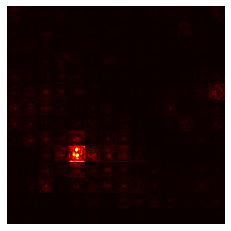

In [ ]:
'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(tensor.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

In [ ]:
probabilities = torch.nn.functional.softmax(out[0], dim=0)
print(probabilities.shape)
# prints: torch.Size([1000])

torch.Size([1000])


In [ ]:
# Get imagenet class mappings
url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
urllib.request.urlretrieve(url, filename) 
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Print top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

def get_top5(img_tensor, probabilities, categories):
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    labels = []
    lab_pos = []
    for i in range(top5_prob.size(0)):
        labels.append(categories[top5_catid[i]])
        lab_pos.append(top5_prob[i].item())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.imshow(np.swapaxes(adv_1[0].T, 0, 1))
    ax2.bar(np.arange(5), lab_pos, color='green')
    ax2.set(xlabel='Labels', ylabel='Probabilities')
    ax2.set_xticks(np.arange(5))
    ax2.set_xticklabels(labels)
    plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')
    fig.suptitle('PGD-20 attack on ViT')
    fig.show()

keeshond 0.2650674283504486
Samoyed 0.26503127813339233
Pomeranian 0.25351497530937195
Eskimo dog 0.015804165974259377
kuvasz 0.015244334936141968


In [ ]:
# TEST
tensor.shape
np.arange(5)*40

array([  0,  40,  80, 120, 160])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=1000,
)

# set up PGD-20 attack
eps = 0.03
attack = ProjectedGradientDescentPyTorch(
        estimator=classifier,
        norm="inf",
        eps=eps,
        targeted=True,
        eps_step=0.05,
        max_iter=20
)

In [ ]:
tensor.requires_grad_(False)
adv_1 = attack.generate(x=tensor, y=np.array([7]))
adv_tensor = torch.from_numpy(adv_1).to('cuda')
adv_tensor.requires_grad_()
out = model(adv_tensor)

out_max_index = out.argmax()
out_max = out[0, out_max_index]
out_max.backward()

/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


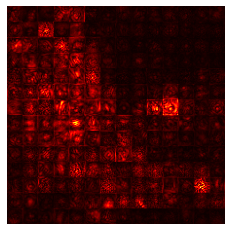

In [ ]:
saliency_adv, _ = torch.max(adv_tensor.grad.data.abs(),dim=1)

saliency_adv = saliency_adv.cpu()

# code to plot the saliency map as a heatmap
plt.imshow(saliency_adv[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

In [ ]:
probabilities = torch.nn.functional.softmax(out[0], dim=0)

top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

cock 0.277165949344635
Pomeranian 0.2471226155757904
papillon 0.08998830616474152
hen 0.06770636141300201
Chihuahua 0.06519042700529099


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


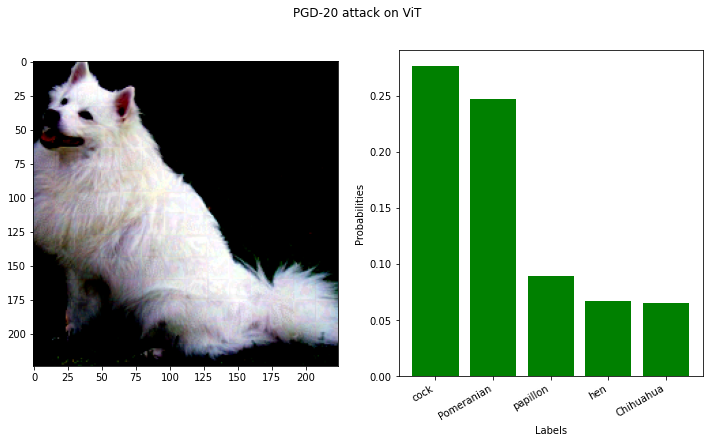

In [ ]:
get_top5(adv_1, probabilities, categories)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


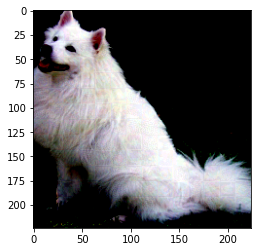

In [ ]:
adv_img = np.swapaxes(adv_1[0].T, 0, 1)
plt.imshow(adv_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


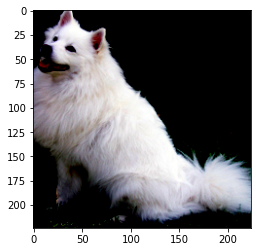

In [ ]:
orig_img = np.swapaxes(tensor[0].T, 0, 1)
plt.imshow(orig_img)